In [1]:
from __future__ import print_function

import h5py, os, sys, glob
sys.path.append('../lib')

# to get newer sklearn for updated GradientBoostingRegressor options
# to get newer numpy for numpy.quantile
!pip install scikit-learn==0.20 --user
!pip install numpy==1.15 --user
sys.path.insert(0,'$HOME/.local/lib/python2.7/site-packages/')

import numpy as np

from glob import glob

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from prettytable import PrettyTable

import ROOT as rt

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

You are using pip version 9.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:12: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/uscms/home/jduarte1/.local/lib/python2

Welcome to JupyROOT 6.12/07


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-root_numpy/4.7.3-gnimlf6/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.0 is currently installed but you installed root_numpy against numpy 1.14.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
Mjj_selection = 700.

vae_loss = 'mae'

SM_eff = 1e-2

def computeDiscriminatingVar(x):
    out = x[:,-2]/x[:,1]+x[:,-1]/x[:,6]
    out *= 1e5
    return out

# Get the discrimination on the side-band

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1Loss', 'j2Loss']
(209109, 13)


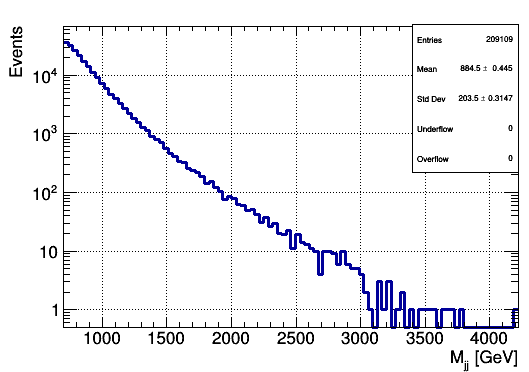

In [3]:
f = h5py.File('../data/vae_'+vae_loss+'/qcd_dEta_sideband_results.h5', 'r')
print(list(f.get("labels")))

data_side = np.array(f.get("results"))

# apply the dijet mass cut
data_side = data_side[data_side[:,0] > Mjj_selection]
print(data_side.shape)

c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_side[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                opt='overflow', 
                binning=[100, Mjj_selection, np.max(data_side[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [4]:
x = np.reshape(data_side[:,0], (-1,1))
y = computeDiscriminatingVar(data_side)
print(np.mean(y))

103.62135082607014


In [5]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=5,
                                min_samples_split=5,
                                validation_fraction=0.5,
                                n_iter_no_change=10,
                                tol=1e-5,
                                verbose=1)


gbr_cut.fit(x, y)

      Iter       Train Loss   Remaining Time 
         1           0.3830           10.40s
         2           0.3824           10.54s
         3           0.3819           10.43s
         4           0.3815           10.35s
         5           0.3811           10.42s
         6           0.3807           10.40s
         7           0.3805           10.72s
         8           0.3802           11.69s
         9           0.3800           12.41s
        10           0.3798           12.96s
        20           0.3787           12.37s


GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             n_iter_no_change=10, presort='auto', random_state=None,
             subsample=1.0, tol=1e-05, validation_fraction=0.5, verbose=1,
             warm_start=False)

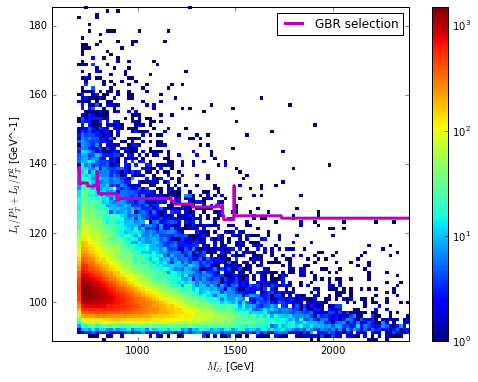

In [6]:
plt.figure(figsize=(8, 6))
x_min = Mjj_selection*0.8
x_max = np.quantile(x, 0.999)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.quantile(y, 1-1e-4))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-x_min))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [7]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

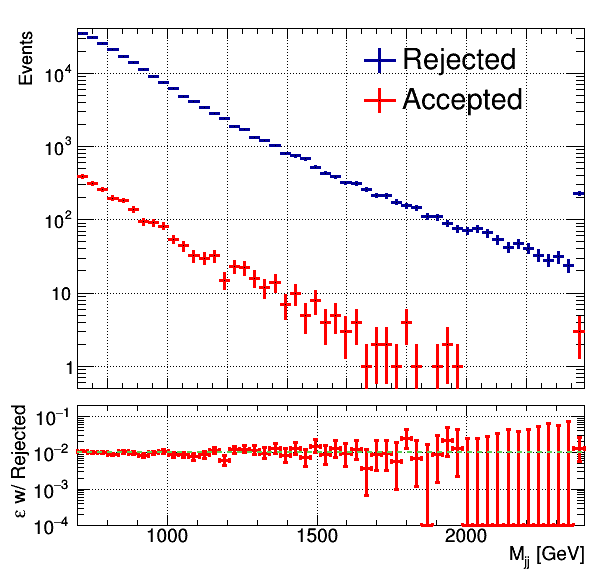

In [8]:
x = x.flatten()
binning=[50, Mjj_selection, np.quantile(x, 0.999)]

sel = getSelection(x, y)
h_a = create_TH1D(x[sel], 
                  name='h_acc', title='Accepted',
                  binning=binning,
                  opt='overflow'
                 )
h_a.SetLineColor(2)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(x[np.logical_not(sel)], 
                  name='h_rej', title='Rejected',
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt='overflow'
                 )
h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
h_r.SetStats(0)
h_r.Sumw2()

c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E')
c.pad1.SetLogy()
c.pad2.SetLogy()

c.pad2.cd()
ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
ln.SetLineWidth(2)
ln.SetLineStyle(7)
ln.SetLineColor(8)
ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

c.Draw()

In [9]:
import scipy as sp
def HypotesisTets(h_a, h_r, eff, N_asymov = 100000, show_hist = False):
    aux, _ = rootTH1_to_np(h_r)
    nu = eff*aux/(1-eff)
    
    o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
    
    probs = sp.stats.poisson.pmf(o_asymov, nu)
    nll = -np.log(probs)
    s_asymov = np.sum(nll, axis=-1)
    
    aux, _ = rootTH1_to_np(h_a)
    probs_obs = sp.stats.poisson.pmf(aux.astype(np.int), nu)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    
    p_val = np.sum(s_asymov > s_obs)/float(N_asymov)
    
    
    if show_hist:
        plt.hist(s_asymov)

    return p_val

In [10]:
HypotesisTets(h_a, h_r, SM_eff)

0.86175

# Prepare combine inputs in signal region

### Get the data

In [11]:
sample_loc = {'qcd':'qcd_dEta_signalregion_results.h5',
              'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_results.h5',
              'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
              'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':'QCD',
                'AtoZZZ':'$A\toZZZ$',
                'GtoWW':'$G\toWW$',
                'GtoBtt':'$G_{B}\tot\bar{t}$',
                'GtoNtt':'$G_{N}\tot\bar{t}$'
               }

BSM_samples = ['AtoZZZ', 'GtoWW', 'GtoBtt', 'GtoNtt']

In [12]:
data = {}
table = PrettyTable()
table.field_names = ['Sample', 'Tot. evts', 'Sel. evts', 'Eff VAE[%]']

for n, fname in sample_loc.iteritems():
    f = h5py.File('../data/vae_'+vae_loss+'/'+fname, 'r')
    x = np.array(f.get("results"))

    # apply the dijet mass cut
    sel_Mjj = x[:,0] > Mjj_selection
    x = x[sel_Mjj]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(x[:,0], dVar)
    x = np.column_stack((x, dVar, sel))
    
    dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.3f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], np.sum(data[n]['sel']), eff])
    
print(table)

+--------+-----------+-----------+------------+
| Sample | Tot. evts | Sel. evts | Eff VAE[%] |
+--------+-----------+-----------+------------+
| GtoBtt |   65666   |   10038   |   15.286   |
| GtoWW  |   53630   |   12357   |   23.041   |
| GtoNtt |   64179   |   10028   |   15.625   |
| AtoZZZ |   65148   |   11253   |   17.273   |
|  qcd   |   471448  |    4721   |   1.001    |
+--------+-----------+-----------+------------+


### See the distributions and dump (scaled) histograms into ROOT file

[30, 700.0, 2000.0]

GtoWW
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin0' created with bounds [700,743.333]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin1' created with bounds [743.333,786.667]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin2' created with bounds [786.667,830]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin3' created with bounds [830,873.333]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin4' created with bounds [873.333,916.667]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin5' created with bounds [916.667,960]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin6' created with bounds [960,1003.33]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin7' created with bounds [1003.33,1046.67]
[#1] INFO

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


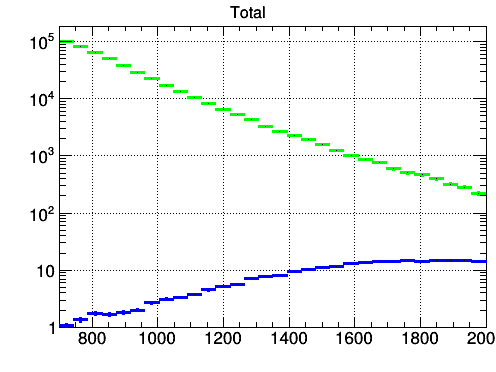

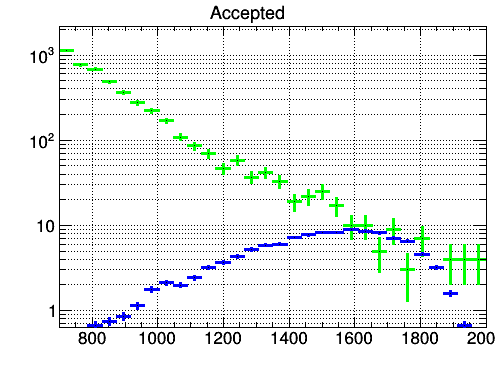

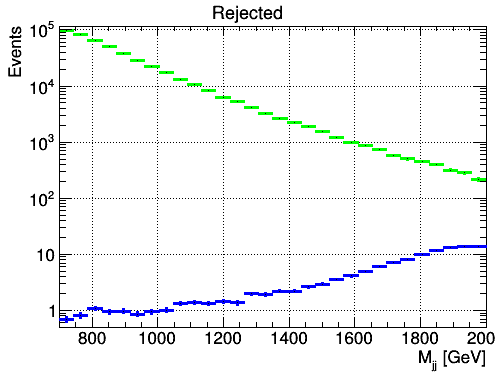

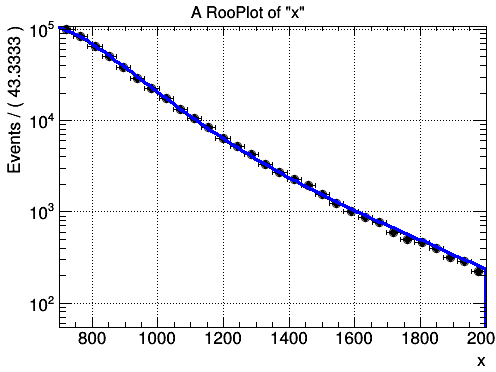

In [13]:
#binning=[50, Mjj_selection, np.quantile(data['qcd']['mJJ'], 0.999)]
binning=[30, Mjj_selection, 2000.0]
# use variable binning?
#[700, 750, 800, 850, 900, 950, 1000, 1050, 1110, 1170, 1240, 1310, 1390, 1470, 1560, 1650, 1750, 1850, 1960, 2070]
print(binning)

# scale factor to scale signal
scale = 0.01

# histogram dictionary
histos = {}

datacard_hist = rt.TFile.Open('datacard_hist.root','recreate')
datacard_ws = rt.TFile.Open('datacard_ws.root','recreate')
w = rt.RooWorkspace('w','w')
x = rt.RooRealVar('x','x',binning[1],binning[2])
w.factory('x[%.1f,%.1f]'%(binning[1],binning[2]))
w.factory('p1[4.1]')
w.factory('p2[7.9]')
w.factory('p3[0.6]')
w.factory('p4[0.025]')
w.factory('sqrts[13000]')
w.factory('qcd_tot_norm[1.]')
w.factory('qcd_bin_tot_norm[1.]')
# CMS 5-parameter
w.factory("EXPR::qcd_tot('max(0.,pow(1-x/sqrts,p1)/pow(x/sqrts,p2+p3*log(x/sqrts)+p4*log(x/sqrts)*log(x/sqrts)))',x,p1,p2,p3,p4,sqrts)")
# ATLAS 5-parameter
#w.factory("EXPR::qcd_tot('max(0.,exp(-p2*(x/sqrts)-p3*pow(x/sqrts,2)-p4*pow(x/sqrts,3))/pow(x/sqrts,p1))',x,p1,p2,p3,p4,sqrts)")

w.var('sqrts').setConstant(True)
w.var('p1').setConstant(False)
w.var('p2').setConstant(False)
w.var('p3').setConstant(False)
w.var('p4').setConstant(False)
w.var('qcd_tot_norm').setConstant(False)
w.var('qcd_bin_tot_norm').setConstant(False)
roolist = rt.RooArgList()
roolist.add(w.var('p1'))
roolist.add(w.var('p2'))
roolist.add(w.var('p3'))
roolist.add(w.var('p4'))
roolist.add(w.var('sqrts'))
empty_hist = rt.TH1D('empty_hist','empy_hist',binning[0],binning[1],binning[2])
qcd_bin_tot = rt.RooParametricShapeBinPdf('qcd_bin_tot', 
                                          'qcd_bin_tot', 
                                          w.pdf('qcd_tot'), 
                                          w.var('x'), 
                                          roolist, 
                                          empty_hist)
getattr(w,'import')(qcd_bin_tot, rt.RooCmdArg())

h_t = create_TH1D(data['qcd']['mJJ'], 
                  name='h_tot', title='Total',
                  binning=binning,
                  opt=''
                 )
h_t.SetLineColor(rt.kGreen)
h_t.SetStats(0)
h_t.Sumw2()

w.factory('eqcd_tot_norm[%.1f]'%h_t.Integral())
w.factory("SUM::eqcd_tot(eqcd_tot_norm*qcd_tot)")
w.factory("SUM::eqcd_bin_tot(eqcd_tot_norm*qcd_bin_tot)")
w.var('eqcd_tot_norm').setConstant(False)

h_a = create_TH1D(data['qcd']['mJJ'][data['qcd']['sel']], 
                  name='h_acc', title='Accepted',
                  binning=binning,
                  opt=''
                 )
h_a.SetLineColor(rt.kGreen)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(data['qcd']['mJJ'][np.logical_not(data['qcd']['sel'])], 
                  name='h_rej', title='Rejected',
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt=''
                 )
h_r.SetLineColor(rt.kGreen)
h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
h_r.SetStats(0)
h_r.Sumw2()

histos['qcd_tot'] = h_t
histos['qcd_acc'] = h_a
histos['qcd_rej'] = h_r
histos['data_obs_tot'] = h_t
histos['data_obs_acc'] = h_a
histos['data_obs_rej'] = h_r
h_t.SetDirectory(0)
h_a.SetDirectory(0)
h_r.SetDirectory(0)

acc_bin_functions = rt.RooArgList()
rej_bin_functions = rt.RooArgList()
w.factory('eff[%f,0,1]'%(h_a.Integral()/h_r.Integral()))
w.var('eff').setConstant(False)
for iBinX in range(1,binning[0]+1):
    w.factory('crBin%i_In[%.1f]'%(iBinX,h_r.GetBinContent(iBinX)))
    w.factory('crBin%i[0,-100,100]'%(iBinX))
    w.var('crBin%i_In'%iBinX).setConstant(True)
    w.var('crBin%i'%iBinX).setConstant(False)
    w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(h_r.GetBinContent(iBinX)),iBinX,iBinX))
    w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
    rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
    acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    
qcd_rph_rej = rt.RooParametricHist('qcd_rph_rej','qcd_rej_acc',w.var('x'),rej_bin_functions,empty_hist)
qcd_rph_rej_norm = rt.RooAddition('qcd_rph_rej_norm','qcd_rph_rej_norm',rej_bin_functions)
qcd_rph_acc = rt.RooParametricHist('qcd_rph_acc','qcd_rph_acc',w.var('x'),acc_bin_functions,empty_hist)
qcd_rph_acc_norm = rt.RooAddition('qcd_rph_acc_norm','qcd_rph_acc_norm',acc_bin_functions)
getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())


for name_BSM in ['GtoWW']:
    print('\n'+name_BSM)
    
    
    h_t_BSM = create_TH1D(data[name_BSM]['mJJ'], 
                  name='h_t'+name_BSM,
                  binning=h_t.binning,
                  opt=''
                 )
    h_t_BSM.SetLineColor(rt.kBlue)
    h_t_BSM.Sumw2()
    h_t_BSM.Scale(scale)
    
    h_a_BSM = create_TH1D(data[name_BSM]['mJJ'][data[name_BSM]['sel']], 
                  name='h_a'+name_BSM,
                  binning=h_a.binning,
                  opt=''
                 )
    h_a_BSM.SetLineColor(rt.kBlue)
    h_a_BSM.Sumw2()
    h_a_BSM.Scale(scale)
    
    h_r_BSM = create_TH1D(data[name_BSM]['mJJ'][np.logical_not(data[name_BSM]['sel'])], 
                  name='h_r'+name_BSM,
                  binning=h_r.binning,
                  opt=''
                 )
    h_r_BSM.SetLineColor(rt.kBlue)
    h_r_BSM.Sumw2()
    h_r_BSM.Scale(scale)

    
    c_t = rt.TCanvas('c_t','c_t',500,400)
    h_t.Draw()
    h_t.SetMinimum(1)
    h_t_BSM.Draw('same')
    c_t.SetLogy()
    c_t.Draw()
    
    c_a = rt.TCanvas('c_a','c_a',500,400)
    h_a.Draw()
    h_a_BSM.Draw('same')
    c_a.SetLogy()
    c_a.Draw()
    
    c_r = rt.TCanvas('c_r','c_r',500,400)
    h_r.Draw()
    h_r_BSM.Draw('same')
    c_r.SetLogy()
    c_r.Draw()
    
    datacard_hist.cd()
    histos[name_BSM+'_tot'] = h_t_BSM
    histos[name_BSM+'_acc'] = h_a_BSM
    histos[name_BSM+'_rej'] = h_r_BSM
    h_t_BSM.SetDirectory(0)
    h_a_BSM.SetDirectory(0)
    h_r_BSM.SetDirectory(0)


for key, histo in histos.iteritems():
    datacard_hist.cd()
    histo.Write(key)
    if 'qcd' not in key:
        ds = rt.RooDataHist(key,key,rt.RooArgList(w.var('x')),histo)
        getattr(w,'import')(ds, rt.RooCmdArg())


nll = w.pdf('eqcd_tot').createNLL(w.data('data_obs_tot'))
m2 = rt.RooMinimizer(nll)
m2.setStrategy(2)
m2.setMaxFunctionCalls(100000)
m2.setMaxIterations(100000)
m2.setPrintLevel(-1)
m2.setPrintEvalErrors(-1)
m2.setEps(1e-5)
m2.optimizeConst(2)
migrad_status = m2.minimize('Minuit2', 'migrad')
improve_status = m2.minimize('Minuit2', 'improve')
hesse_status = m2.minimize('Minuit2', 'hesse')
fr = m2.save()

fr.Print('v')

datacard_ws.cd()
w.Write()
datacard_hist.Close()
datacard_ws.Close()


c_frame = rt.TCanvas('c_frame','c_frame',500,400)
frame = w.var('x').frame()
w.data('data_obs_tot').plotOn(frame)
w.pdf('eqcd_tot').plotOn(frame)
frame.Draw()
c_frame.Draw()
c_frame.SetLogy()

w.Print('v')

## Define datacard based on histogram template fit

In [14]:
datacard = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         {BSM}     qcd
process         0          1
rate            {BSMRATE}    {QCDRATE}
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1
'''

datacard_ws = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         {BSM}     qcd
process         0          1
rate            {BSMRATE}    {QCDRATE}
--------------------------------
lumi     lnN    1.10       -
qcd_{BIN}_norm   flatParam
p1   flatParam
p2   flatParam
p3   flatParam
p4   flatParam
'''



datacard_ratio = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         {BSM}     qcd_rph
process         0          1
rate            {BSMRATE}    {QCDRATE}
--------------------------------
lumi     lnN    1.10       -
eff   flatParam
'''

In [15]:
datacard_tot = datacard.format(BIN='tot',
                          OBS=h_t.Integral(),
                          QCDRATE=h_t.Integral(),
                          BSM=name_BSM,
                          BSMRATE=h_t_BSM.Integral())
print(datacard_tot)
with open('datacard_tot.txt','w') as f:
    f.write(datacard_tot)
    
datacard_acc = datacard.format(BIN='acc',
                          OBS=h_a.Integral(),
                          QCDRATE=h_a.Integral(),
                          BSM=name_BSM,
                          BSMRATE=h_a_BSM.Integral())
print(datacard_acc)
with open('datacard_acc.txt','w') as f:
    f.write(datacard_acc)
    
    
datacard_ws_tot = datacard_ws.format(BIN='tot',
                          OBS=h_t.Integral(),
                          QCDRATE=h_t.Integral(),
                          BSM=name_BSM,
                          BSMRATE=h_t_BSM.Integral())
print(datacard_ws_tot)
with open('datacard_ws_tot.txt','w') as f:
    f.write(datacard_ws_tot)
    
    
datacard_ratio_acc = datacard_ratio.format(BIN='acc',
                          OBS=h_a.Integral(),
                          QCDRATE=1,
                          BSM=name_BSM,
                          BSMRATE=h_a_BSM.Integral())
print(datacard_ratio_acc)
with open('datacard_ratio_acc.txt','w') as f:
    f.write(datacard_ratio_acc)
    
    
datacard_ratio_rej = datacard_ratio.format(BIN='rej',
                          OBS=h_r.Integral(),
                          QCDRATE=1,
                          BSM=name_BSM,
                          BSMRATE=h_r_BSM.Integral())
print(datacard_ratio_rej)
with open('datacard_ratio_rej.txt','w') as f:
    f.write(datacard_ratio_rej)


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin tot
observation 469965.0
------------------------------
bin             tot      tot
process         GtoWW     qcd
process         0          1
rate            246.72    469965.0
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin acc
observation 4709.0
------------------------------
bin             acc      acc
process         GtoWW     qcd
process         0          1
rate            121.82    4709.0
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin 

# Run combine

In [16]:
# using "total" region with MC templates
#!combine -M AsymptoticLimits -d datacard_tot.txt
# using "total" region with dijet fit method
!combine -M AsymptoticLimits -d datacard_ws_tot.txt 

 <<< Combine >>> 
>>> method used is AsymptoticLimits
>>> random number generator seed is 123456

 -- AsymptoticLimits ( CLs ) --
Observed Limit: r < 0.3711
Expected  2.5%: r < 1.0719
Expected 16.0%: r < 1.2255
Expected 50.0%: r < 1.2305
Expected 84.0%: r < 2.4763
Expected 97.5%: r < 3.0200

Done in 0.02 min (cpu), 0.02 min (real)


In [17]:
# using "accept" region with MC templates
#!combine -M AsymptoticLimits -d datacard_acc.txt -t -1 --toysFreq
# using combination of "accept" and "reject" regions with ratio method
!combineCards.py rej=datacard_ratio_rej.txt acc=datacard_ratio_acc.txt > datacard_ratio.txt
!combine -M AsymptoticLimits -d datacard_ratio.txt 

 <<< Combine >>> 
>>> method used is AsymptoticLimits
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplicated
Object crBin24Func is duplicated
Object crBin25Func is duplicated
Object crBin26Func is duplicated
Object crBin27Func is duplicated
Object crBin28Func is

In [18]:
# get some post-fit plots
!combine -M FitDiagnostics -d datacard_ws_tot.txt --plots  --setParameters p1=4.1,p2=7.9,p3=0.6,p4=0.025,r=0
!combine -M FitDiagnostics -d datacard_ratio.txt --plots

 <<< Combine >>> 
>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-rwEOsq.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Set Default Value of Parameter p1 To : 4.1
Set Default Value of Parameter p2 To : 7.9
Set Default Value of Parameter p3 To : 0.6
Set Default Value of Parameter p4 To : 0.025
Set Default Value of Parameter r To : 0
[utils::makePlots] Number of events for pdf in tot_x, pdf pdf_bintot = 470212
Error in <TList::Clear>: A list is accessing an object (0x7e31a84) already deleted (list name = TList)
Info in <TCanvas::Print>: png file ./tot_x_prefit.png has been created
Info in <TCanvas::Print>: png file ./tot_x_prefit_logy.png has been created
[#0] WARNING:Minization -- RooMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (9.78485) to force MIGRAD to back out of this region. Error log f

[#0] WARNING:Minization -- RooMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (9.78485) to force MIGRAD to back out of this region. Error log follows
Parameter values: lumi=-2.20732, p1=1700.95, p2=-1174.9, p3=-330.219, p4=-33.1758, r=17.7928, shapeBkg_qcd_tot__norm=0.990318
RooGenericPdf::shapeBkg_qcd_tot[ actualVars=(x,p1,p2,p3,p4,sqrts) formula="max(0.,pow(1-x/sqrts,p1)/pow(x/sqrts,p2+p3*log(x/sqrts)+p4*log(x/sqrts)*log(x/sqrts)))" ]
     p.d.f normalization integral is zero or negative @ actualVars=(x = 721.667,p1 = 1700.95 +/- 0.59174,p2 = -1174.9 +/- 0.107795,p3 = -330.219 +/- 0.0201714,p4 = -33.1758 +/- 0.00439091,sqrts = 13000)
     p.d.f normalization integral is zero or negative @ actualVars=(x = 765,p1 = 1700.95 +/- 0.59174,p2 = -1174.9 +/- 0.107795,p3 = -330.219 +/- 0.0201714,p4 = -33.1758 +/- 0.00439091,sqrts = 13000)
     p.d.f normalization integral is zero or negative @ actualVars=(x = 808.333,p1 = 1700.95 +/- 0.59174,p2 = -1174.9 +/- 0.1

[#0] WARNING:Minization -- RooMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (31515.6) to force MIGRAD to back out of this region. Error log follows
Parameter values: lumi=3115.98, p1=647.857, p2=-36261.8, p3=296856, p4=-1.13941e+06, r=8.32577, shapeBkg_qcd_tot__norm=98194.5
RooGenericPdf::shapeBkg_qcd_tot[ actualVars=(x,p1,p2,p3,p4,sqrts) formula="max(0.,pow(1-x/sqrts,p1)/pow(x/sqrts,p2+p3*log(x/sqrts)+p4*log(x/sqrts)*log(x/sqrts)))" ]
     p.d.f normalization integral is zero or negative @ actualVars=(x = 721.667,p1 = 647.857 +/- 0.59174,p2 = -36261.8 +/- 0.107795,p3 = 296856 +/- 0.0201714,p4 = -1.13941e+06 +/- 0.00439091,sqrts = 13000)
     p.d.f normalization integral is zero or negative @ actualVars=(x = 765,p1 = 647.857 +/- 0.59174,p2 = -36261.8 +/- 0.107795,p3 = 296856 +/- 0.0201714,p4 = -1.13941e+06 +/- 0.00439091,sqrts = 13000)
     p.d.f normalization integral is zero or negative @ actualVars=(x = 808.333,p1 = 647.857 +/- 0.59174,p2 = -36261.8

Info in <TCanvas::Print>: png file ./covariance_fit_s.png has been created

 --- FitDiagnostics ---
Best fit r: 0.119372  -0.119372/+0.137614  (68% CL)
Done in 0.11 min (cpu), 0.11 min (real)


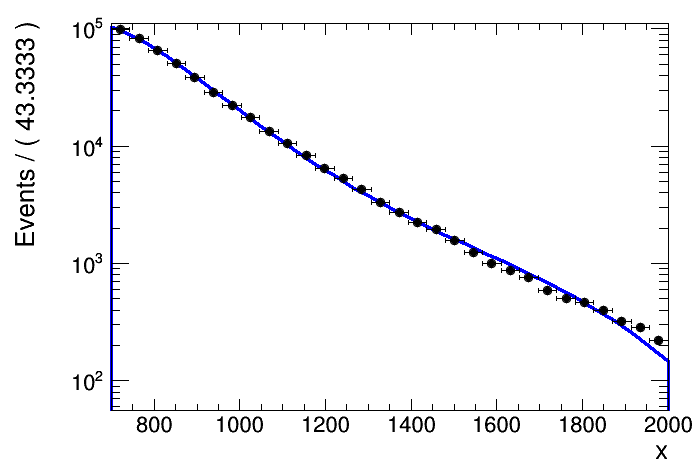

In [19]:
from IPython.display import Image
Image(filename='tot_x_fit_b_logy.png')

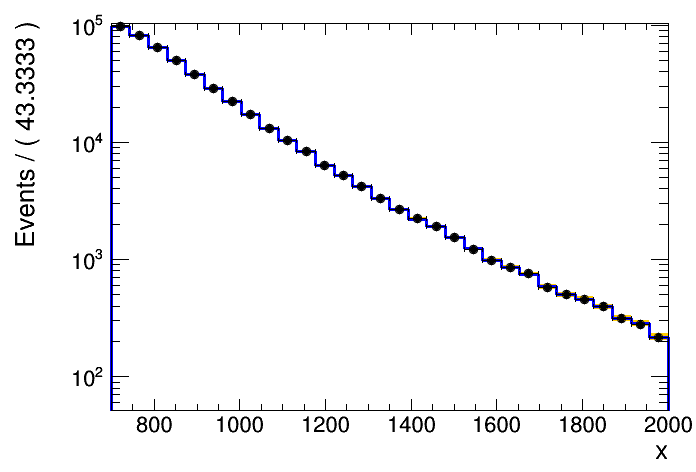

In [20]:
Image(filename='rej_x_fit_b_logy.png')

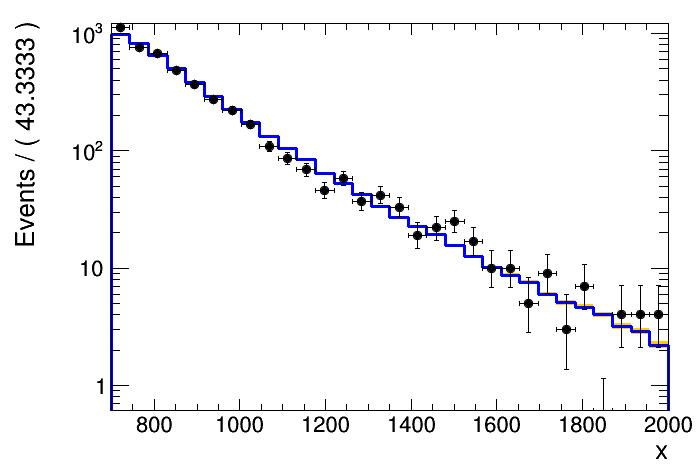

In [21]:
Image(filename='acc_x_fit_b_logy.png')